# School Zone Total Returns Analysis

This notebook explores the relationship between real estate investment returns and public school zones. By combining geographic data on school boundaries with total return data at the ZIP code level, we aim to estimate how school quality and district boundaries correlate with real estate performance.

### Objective

The objective is to:
- Map ZIP-code-level real estate total returns to individual school zones.
- Identify patterns or correlations between school quality and investment returns.
- Enable dynamic queries through the NCREIF (National Council of Real Estate Investment Fiduciaries) data interface using spatial joins.

### Data Sources
- **School scores Dataset**
    The Educational Opportunity Project at Stanford University has built the first national database of academic performance. We create applications, research reports, and interactive articles to enable anyone to explore and understand our data.
    [SEDA School File](https://edopportunity.org/opportunity/data/)

- **School Zone Relationship File**  
  A file from the National Center for Education Statistics (NCES) that maps ZIP codes to school district and attendance boundaries:  
  [NCES School Zone Relationship Files](https://nces.ed.gov/programs/edge/geographic/relationshipfiles)

- **Real Estate Return Data**  
  Total return data provided by NCREIF, available by ZIP code. This data includes appreciation and income return metrics for real estate investments.

### Process Overview

1. Load school zone to ZIP code relationship data.
2. Join real estate return data with school zones using ZIP code as the common key.
3. Set up `WHERE` clauses to query NCREIF for specific geographies corresponding to school zones.
4. Visualize and analyze return patterns across different zones and school quality tiers.

This workflow enables a deeper understanding of how educational infrastructure and district boundaries influence real estate investment outcomes.

In [54]:
import pandas as pd
from ncreif_credentials import ncreif_username, ncreif_password
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis


In [2]:
seda = pd.read_csv('seda_geodist_long_cs_5.0_updated_20240319.csv')


In [3]:
## Get the zips to schoolzones

zip_to_sz = pd.read_excel('grf24_lea_zcta5ce20.xlsx')

zip_to_sz.columns = zip_to_sz.columns.str.lower() #lower case to match seda data

# Rename the columns
zip_to_sz = zip_to_sz.rename(columns={
    'leaid': 'sedalea'     # Rename leaid to sedalea to match seda data
})

#keep the duplicate with the largest landarea.
zip_to_sz = (
    zip_to_sz
    .sort_values('landarea', ascending=False)   # Sort largest first
    .drop_duplicates(subset='zcta5ce20', keep='first')  # Keep the first (largest landarea)
    .reset_index(drop=True)
)

# Check to make sure it worked
zip_to_sz.columns


Index(['sedalea', 'name_lea24', 'zcta5ce20', 'count', 'landarea', 'waterarea'], dtype='object')

In [4]:
## Get the CBSAs to schoolzones - this is to reduce down the number of calls to the NCREIF database
cbsa_to_sz = pd.read_excel('grf24_lea_cbsa.xlsx')
cbsa_to_sz.columns = cbsa_to_sz.columns.str.lower() #lower case to match seda data

# Rename the columns
cbsa_to_sz = cbsa_to_sz.rename(columns={
    'leaid': 'sedalea'     # Rename leaid to sedalea to match seda data
})

cbsa_to_sz.columns


Index(['sedalea', 'name_lea24', 'cbsa', 'name_cbsa24', 'count', 'landarea',
       'waterarea'],
      dtype='object')



# SEDA Data Dictionary

| Column Name | Label | Source | Description/Notes |
|:------------|:------|:-------|:------------------|
| fips | State FIPS Code | ID | |
| stateabb | State Abbreviation | ID | |
| sedalea | SEDA LEA ID | ID | |
| sedaleaname | Geographic District Name | SEDA HETOP using EDFacts data | |
| subject | Tested Subject | EdFacts Grade-year-subject gyb Identifiers | "math" (Mathematics) or "ela" (English/Language Arts) |
| grade | Tested Grade | EdFacts Grade-year-subject gyb Identifiers | Grades 3-8 included |
| year | Spring of Tested Year | EdFacts Grade-year-subject gyb Identifiers | Years 2008-09 through 2018-19 included |
| cs_mn_all | District Subject-Grade-Year Mean, All Students | SEDA HETOP using EDFacts data | Cohort Scale (CS) |
| cs_mn_se_all | SE of Subject-Grade-Year Mean, All Students | SEDA HETOP using EDFacts data | Cohort Scale (CS) |
| tot_asmt_all | Number Tested, All Students | SEDA HETOP using EDFacts data | |
| cs_mn_asn | District Mean, Asian Students | SEDA HETOP using EDFacts data | Cohort Scale (CS) |
| cs_mn_se_asn | SE of Mean, Asian Students | SEDA HETOP using EDFacts data | Cohort Scale (CS) |
| tot_asmt_asn | Number Tested, Asian Students | SEDA HETOP using EDFacts data | |
| cs_mn_blk | District Mean, Black Students | SEDA HETOP using EDFacts data | Cohort Scale (CS) |
| cs_mn_se_blk | SE of Mean, Black Students | SEDA HETOP using EDFacts data | Cohort Scale (CS) |
| tot_asmt_blk | Number Tested, Black Students | SEDA HETOP using EDFacts data | |
| cs_mn_ecd | District Mean, Economically Disadvantaged (ECD) Students | SEDA HETOP using EDFacts data | Cohort Scale (CS) |
| cs_mn_se_ecd | SE of Mean, ECD Students | SEDA HETOP using EDFacts data | Cohort Scale (CS) |
| tot_asmt_ecd | Number Tested, ECD Students | SEDA HETOP using EDFacts data | |
| cs_mn_fem | District Mean, Female Students | SEDA HETOP using EDFacts data | Cohort Scale (CS) |
| cs_mn_se_fem | SE of Mean, Female Students | SEDA HETOP using EDFacts data | Cohort Scale (CS) |
| tot_asmt_fem | Number Tested, Female Students | SEDA HETOP using EDFacts data | |
| cs_mn_hsp | District Mean, Hispanic Students | SEDA HETOP using EDFacts data | Cohort Scale (CS) |
| cs_mn_se_hsp | SE of Mean, Hispanic Students | SEDA HETOP using EDFacts data | Cohort Scale (CS) |
| tot_asmt_hsp | Number Tested, Hispanic Students | SEDA HETOP using EDFacts data | |
| cs_mn_mal | District Mean, Male Students | SEDA HETOP using EDFacts data | Cohort Scale (CS) |
| cs_mn_se_mal | SE of Mean, Male Students | SEDA HETOP using EDFacts data | Cohort Scale (CS) |
| tot_asmt_mal | Number Tested, Male Students | SEDA HETOP using EDFacts data | |
| cs_mn_mfg | District Male-Female Gap | SEDA HETOP using EDFacts data | Cohort Scale (CS) |
| cs_mn_se_mfg | SE of Male-Female Gap | SEDA HETOP using EDFacts data | Cohort Scale (CS) |
| tot_asmt_mfg | Number Tested, Male & Female Students | SEDA HETOP using EDFacts data | |
| cs_mn_nam | District Mean, Native American Students | SEDA HETOP using EDFacts data | Cohort Scale (CS) |
| cs_mn_se_nam | SE of Mean, Native American Students | SEDA HETOP using EDFacts data | Cohort Scale (CS) |
| tot_asmt_nam | Number Tested, Native American Students | SEDA HETOP using EDFacts data | |
| cs_mn_nec | District Mean, Non-ECD Students | SEDA HETOP using EDFacts data | Cohort Scale (CS) |
| cs_mn_se_nec | SE of Mean, Non-ECD Students | SEDA HETOP using EDFacts data | Cohort Scale (CS) |
| tot_asmt_nec | Number Tested, Non-ECD Students | SEDA HETOP using EDFacts data | |
| cs_mn_neg | Non-ECD vs ECD Gap | SEDA HETOP using EDFacts data | Cohort Scale (CS) |
| cs_mn_se_neg | SE of Non-ECD vs ECD Gap | SEDA HETOP using EDFacts data | Cohort Scale (CS) |
| tot_asmt_neg | Number Tested, Non-ECD & ECD Students | SEDA HETOP using EDFacts data | |
| cs_mn_wag | White-Asian Gap | SEDA HETOP using EDFacts data | Cohort Scale (CS) |
| cs_mn_se_wag | SE of White-Asian Gap | SEDA HETOP using EDFacts data | Cohort Scale (CS) |
| tot_asmt_wag | Number Tested, White & Asian Students | SEDA HETOP using EDFacts data | |
| cs_mn_wbg | White-Black Gap | SEDA HETOP using EDFacts data | Cohort Scale (CS) |
| cs_mn_se_wbg | SE of White-Black Gap | SEDA HETOP using EDFacts data | Cohort Scale (CS) |
| tot_asmt_wbg | Number Tested, White & Black Students | SEDA HETOP using EDFacts data | |
| cs_mn_whg | White-Hispanic Gap | SEDA HETOP using EDFacts data | Cohort Scale (CS) |
| cs_mn_se_whg | SE of White-Hispanic Gap | SEDA HETOP using EDFacts data | Cohort Scale (CS) |
| tot_asmt_whg | Number Tested, White & Hispanic Students | SEDA HETOP using EDFacts data | |
| cs_mn_wht | District Mean, White Students | SEDA HETOP using EDFacts data | Cohort Scale (CS) |
| cs_mn_se_wht | SE of Mean, White Students | SEDA HETOP using EDFacts data | Cohort Scale (CS) |
| tot_asmt_wht | Number Tested, White Students | SEDA HETOP using EDFacts data | |
| cs_mn_wng | White-Native American Gap | SEDA HETOP using EDFacts data | Cohort Scale (CS) |
| cs_mn_se_wng | SE of White-Native American Gap | SEDA HETOP using EDFacts data | Cohort Scale (CS) |
| tot_asmt_wng | Number Tested, White & Native American Students | SEDA HETOP using EDFacts data | |

In [38]:
#saving an unfiltered, unsorted table
seda_all = seda

In [39]:
# We want to work off the most recent data for each school zone.
seda = seda[seda['year'] == 2019]


# Sort so that when we group, we know the most recent year will come first
seda = seda.sort_values('year', ascending=False)

# Pick the first instance per district for ID fields
id_fields = seda.groupby('sedalea').first().reset_index()

# --- Simple Average Method ---
district_rating = (
    seda
    .groupby('sedalea')
    .agg(
        average_school_quality=('cs_mn_all', 'mean')
    )
    .reset_index()
)

# Merge back ID fields
district_rating = district_rating.merge(
    id_fields[['sedalea', 'fips', 'stateabb', 'sedaleaname', 'year']],
    on='sedalea',
    how='left'
)

# --- Weighted Average Method --- Weighted by Number Tested, All Students ---
seda['weighted_score'] = seda['cs_mn_all'] * seda['tot_asmt_all'] 

district_rating_weighted = (
    seda
    .groupby('sedalea')
    .agg(
        total_weighted_score=('weighted_score', 'sum'),
        total_students=('tot_asmt_all', 'sum')
    )
    .assign(average_school_quality=lambda df: df['total_weighted_score'] / df['total_students']))

district_rating_weighted = district_rating_weighted.reset_index()



## Analyize the data

In [45]:

district_rating[district_rating['stateabb'] == 'MN'].sort_values('average_school_quality')

,sedalea,average_school_quality,fips,stateabb,sedaleaname,year
4848,2730510,-0.949431,27,MN,Red Lake Public School District,2019
4689,2706240,-0.903779,27,MN,Brooklyn Center School District,2019
4694,2707320,-0.779676,27,MN,Butterfield Public School District,2019
4701,2708070,-0.570304,27,MN,Cass Lake-Bena Public Schools,2019
4735,2712180,-0.558149,27,MN,Fisher Public School District,2019
...,...,...,...,...,...,...
4727,2711250,0.721770,27,MN,Edina Public School District,2019
4718,2710170,0.758885,27,MN,Delano Public School District,2019
4826,2725080,0.782421,27,MN,Orono Public School District,2019
4902,2742160,0.859917,27,MN,Wayzata Public School District,2019


In [47]:
district_rating.describe()

,sedalea,average_school_quality,fips,year
count,1.048100e+04,10481.000000,10481.000000,10481.0
mean,2.963614e+06,0.000186,29.502910,2019.0
std,1.506594e+06,0.377955,15.060096,0.0
min,1.000050e+05,-1.951269,1.000000,2019.0
25%,1.800480e+06,-0.236358,18.000000,2019.0
50%,2.916770e+06,-0.001396,29.000000,2019.0
75%,4.204530e+06,0.223834,42.000000,2019.0
max,5.606240e+06,1.594127,56.000000,2019.0


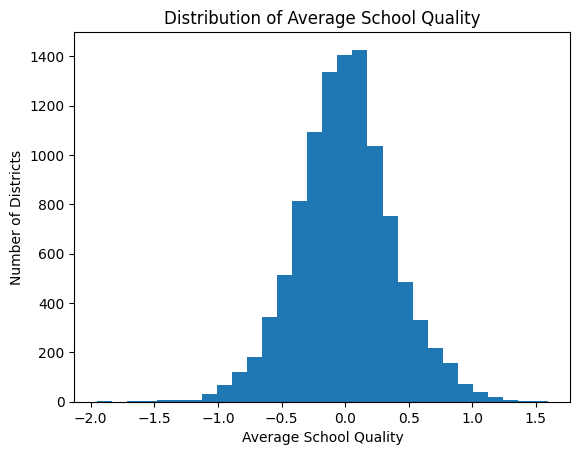

In [50]:


plt.hist(district_rating['average_school_quality'], bins=30)
plt.title('Distribution of Average School Quality')
plt.xlabel('Average School Quality')
plt.ylabel('Number of Districts')
plt.show()

In [52]:

skewness = skew(district_rating['average_school_quality'])
kurt = kurtosis(district_rating['average_school_quality'])

print(f"Skewness: {skewness:.2f}")
print(f"Kurtosis: {kurt:.2f}")

Skewness: 0.02
Kurtosis: 0.67


In [62]:
district_rating_weighted.describe()

,total_weighted_score,total_students,average_school_quality
count,10481.000000,10481.000000,10481.000000
mean,-76.763400,3569.493083,-0.000990
std,3835.033642,11464.827379,0.378095
min,-193171.702441,20.000000,-1.944165
25%,-218.097889,504.000000,-0.238325
50%,-1.050393,1167.000000,-0.001976
75%,244.918374,2930.000000,0.222889
max,52153.383701,548298.000000,1.583607


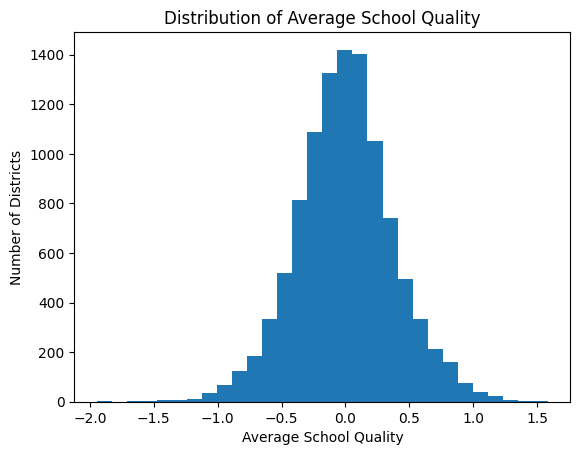

Skewness: 0.02
Kurtosis: 0.67


,sedalea,total_weighted_score,total_students,average_school_quality
0,100005,-2047.045928,5146,-0.397794
1,100006,-2539.337825,5106,-0.497324
2,100007,3842.301459,12801,0.300156
3,100008,5347.729806,10002,0.534666
4,100011,-707.073382,1890,-0.374113


In [55]:

plt.hist(district_rating_weighted['average_school_quality'], bins=30)
plt.title('Distribution of Weighted Average School Quality')
plt.xlabel('Average School Quality')
plt.ylabel('Number of Districts')
plt.show()

skewness = skew(district_rating['average_school_quality'])
kurt = kurtosis(district_rating['average_school_quality'])

print(f"Skewness: {skewness:.2f}")
print(f"Kurtosis: {kurt:.2f}")

district_rating_weighted.head(5) #.describe()

In [63]:
bins = [-float('inf'), -0.60, -0.20, 0.20, 0.60, float('inf')]
labels = ['Very Low', 'Low', 'Average', 'High', 'Very High']

district_rating['quality_category'] = pd.cut(
    district_rating['average_school_quality'],
    bins=bins,
    labels=labels
)

district_rating_weighted['quality_category'] = pd.cut(
    district_rating_weighted['average_school_quality'],
    bins=bins,
    labels=labels
)

In [66]:
district_rating_weighted.head(5)

,sedalea,total_weighted_score,total_students,average_school_quality,quality_category
0,100005,-2047.045928,5146,-0.397794,Low
1,100006,-2539.337825,5106,-0.497324,Low
2,100007,3842.301459,12801,0.300156,High
3,100008,5347.729806,10002,0.534666,High
4,100011,-707.073382,1890,-0.374113,Low


In [70]:
## Find the zip code for each school.

zip_to_sz['sedalea'] = zip_to_sz['sedalea'].astype(str)
district_rating['sedalea'] = district_rating['sedalea'].astype(str)
district_rating_weighted['sedalea'] = district_rating_weighted['sedalea'].astype(str)

# Merge zip_to_sz with district_rating (simple average)
zip_to_sz_simple = zip_to_sz.merge(
    district_rating,
    on='sedalea',  # Key: school district ID
    how='left'
)

# Merge zip_to_sz with district_rating_weighted (weighted average)
zip_to_sz_weighted = zip_to_sz.merge(
    district_rating_weighted,
    on='sedalea',  # Key: school district ID
    how='left'
)

## Eliminate zips without scores
#zip_to_sz_weighted = zip_to_sz_weighted[zip_to_sz_weighted['total_weighted_score'].isna()==False].head()


# Check your outputs
zip_to_sz_weighted



,sedalea,name_lea24,zcta5ce20,count,landarea,waterarea,total_weighted_score,total_students,average_school_quality,quality_category
0,200610,North Slope Borough School District,00000,11,86028.568220,5774.109181,NaN,NaN,NaN,NaN
1,200710,Southwest Region School District,99576,8,11399.243589,516.317171,NaN,NaN,NaN,NaN
2,200775,Yukon Flats School District,99740,12,8050.537514,178.066462,NaN,NaN,NaN,NaN
3,200862,Yukon-Koyukuk School District,99768,15,8009.615827,120.133968,NaN,NaN,NaN,NaN
4,200070,Copper River School District,99566,7,7759.413692,1846.637528,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
33785,4110040,Portland School District 1J,97258,34,0.002617,0.000000,-67.716883,10941.0,-0.006189,Average
33786,3620580,New York City Department Of Education,10115,216,0.002555,0.000000,NaN,NaN,NaN,NaN
33787,3620580,New York City Department Of Education,10177,216,0.002093,0.000000,NaN,NaN,NaN,NaN
33788,3620580,New York City Department Of Education,10169,216,0.002083,0.000000,NaN,NaN,NaN,NaN


In [81]:
# Ensure consistent types
zip_to_sz['sedalea'] = zip_to_sz['sedalea'].astype(str)
zip_to_sz['zcta5ce20'] = zip_to_sz['zcta5ce20'].astype(str).str.zfill(5)

cbsa_to_sz['sedalea'] = cbsa_to_sz['sedalea'].astype(str)

district_rating_weighted['sedalea'] = district_rating_weighted['sedalea'].astype(str)


# Merge first
zip_scores = zip_to_sz.merge(
    district_rating_weighted[['sedalea', 'average_school_quality','quality_category']],
    on='sedalea',
    how='left'
)

zip_scores[zip_scores['quality_category'].isnull()==False].reset_index(drop=True)



,sedalea,name_lea24,zcta5ce20,count,landarea,waterarea,average_school_quality,quality_category
0,3200480,Washoe County School District,89412,29,2800.675737,36.340476,-0.077980,Average
1,403950,Indian Oasis-Baboquivari Unified District,85634,4,2760.706843,0.494029,-1.015385,Very Low
2,3200360,Nye County School District,89049,12,2445.538629,1.036026,-0.377010,Low
3,3017580,Malta K-12 Schools,59538,7,2234.824108,60.796254,0.076559,Average
4,5602140,Converse County School District 1,82633,5,2229.076873,8.987893,0.382304,High
...,...,...,...,...,...,...,...,...
28094,2400090,Baltimore City Public Schools,21287,33,0.003324,0.000000,-0.773960,Very Low
28095,4704350,Warren County School District,38550,7,0.003004,0.000000,-0.178353,Average
28096,803360,Denver County School District 1,80293,41,0.002980,0.000000,-0.009113,Average
28097,4110040,Portland School District 1J,97258,34,0.002617,0.000000,-0.006189,Average


,sedalea,name_lea24,zcta5ce20,count,landarea,waterarea,average_school_quality,quality_category
0,3200480,Washoe County School District,89412,29,2800.675737,36.340476,-0.077980,Average
1,403950,Indian Oasis-Baboquivari Unified District,85634,4,2760.706843,0.494029,-1.015385,Very Low
2,3200360,Nye County School District,89049,12,2445.538629,1.036026,-0.377010,Low
3,3017580,Malta K-12 Schools,59538,7,2234.824108,60.796254,0.076559,Average
4,5602140,Converse County School District 1,82633,5,2229.076873,8.987893,0.382304,High
...,...,...,...,...,...,...,...,...
28094,2400090,Baltimore City Public Schools,21287,33,0.003324,0.000000,-0.773960,Very Low
28095,4704350,Warren County School District,38550,7,0.003004,0.000000,-0.178353,Average
28096,803360,Denver County School District 1,80293,41,0.002980,0.000000,-0.009113,Average
28097,4110040,Portland School District 1J,97258,34,0.002617,0.000000,-0.006189,Average


In [80]:
# Create a Where Statement for each school district
result = (
    zip_scores
    .groupby('sedalea')
    .agg(
        total_weighted_score=('average_school_quality', 'first'),
        zip_where=('zcta5ce20', lambda x: tuple(x.astype(str)))
    )
    .reset_index()
)

# Optional: make zip_where nice string for SQL
result['zip_where'] = result['zip_where'].apply(lambda z: str(z))

#Add in CBSA
result = cbsa_to_sz.merge(result)

# Preview
result.head()


,sedalea,name_lea24,cbsa,name_cbsa24,count,landarea,waterarea,total_weighted_score,zip_where
0,100480,Bullock County School District,0,NOT IN CBSA,1,622.815365,2.328124,-1.080719,"('36089', '36029')"
1,100510,Butler County School District,0,NOT IN CBSA,1,776.838560,1.042939,-0.848223,"('36037', '36033', '36030')"
2,100630,Cherokee County School District,0,NOT IN CBSA,1,553.462622,46.513770,-0.332079,"('35960', '36272', '35973', '35959', '35983')"
3,100690,Choctaw County School District,0,NOT IN CBSA,1,913.479168,7.380081,-0.862391,"('36904', '36919', '36912', '36908', '36921', ..."
4,100720,Clarke County School District,0,NOT IN CBSA,1,1132.637570,14.097065,-0.454769,"('36545', '36451', '36524', '36482', '36727', ..."


In [83]:
zip_scores[zip_scores['quality_category'].isnull()==False].reset_index(drop=True)


,sedalea,name_lea24,zcta5ce20,count,landarea,waterarea,average_school_quality,quality_category
0,3200480,Washoe County School District,89412,29,2800.675737,36.340476,-0.077980,Average
1,403950,Indian Oasis-Baboquivari Unified District,85634,4,2760.706843,0.494029,-1.015385,Very Low
2,3200360,Nye County School District,89049,12,2445.538629,1.036026,-0.377010,Low
3,3017580,Malta K-12 Schools,59538,7,2234.824108,60.796254,0.076559,Average
4,5602140,Converse County School District 1,82633,5,2229.076873,8.987893,0.382304,High
...,...,...,...,...,...,...,...,...
28094,2400090,Baltimore City Public Schools,21287,33,0.003324,0.000000,-0.773960,Very Low
28095,4704350,Warren County School District,38550,7,0.003004,0.000000,-0.178353,Average
28096,803360,Denver County School District 1,80293,41,0.002980,0.000000,-0.009113,Average
28097,4110040,Portland School District 1J,97258,34,0.002617,0.000000,-0.006189,Average


In [85]:
# Create a Where Statement for each quality score district
result_quality = (
    zip_scores
    .groupby('quality_category')
    .agg(
        total_weighted_score=('average_school_quality', 'first'),
        zip_where=('zcta5ce20', lambda x: tuple(x.astype(str)))
    )
    .reset_index()
)

# # Optional: make zip_where nice string for SQL
# result_quality['zip_where'] = result_quality['zip_where'].apply(lambda z: str(z))

# #Add in CBSA
# result_quality = cbsa_to_sz.merge(result)

# Preview
result_quality.head()

,quality_category,total_weighted_score,zip_where
0,Very Low,-1.015385,"(85634, 59645, 78880, 57625, 86033, 92266, 797..."
1,Low,-0.377010,"(89049, 89301, 89445, 89835, 83226, 83278, 769..."
2,Average,-0.077980,"(89412, 59538, 81640, 83539, 89820, 89310, 894..."
3,High,0.382304,"(82633, 82414, 82834, 81641, 82701, 84741, 692..."
4,Very High,0.645604,"(78837, 80487, 82801, 59412, 79331, 69156, 574..."


In [72]:
result = result[result['cbsa']!=0]

In [74]:
result = result[result['total_weighted_score'].notnull()].reset_index()
result

,level_0,index,sedalea,name_lea24,cbsa,name_cbsa24,count,landarea,waterarea,total_weighted_score,zip_where
0,0,2292,500001,DeWitt School District,38220,"Pine Bluff, AR Micro Area",2,86.255407,9.921998,-0.063572,"('72042', '72166', '72055', '72003', '72048', ..."
1,1,2294,500028,Star City School District,38220,"Pine Bluff, AR Micro Area",2,28.739744,0.006478,-0.723359,"('71667', '71644', '71678')"
2,2,2296,500030,Nevada School District,15780,"Camden, AR Micro Area",2,7.532238,0.000000,-0.508769,"('71858', '71835', '71864')"
3,3,2298,500032,Bearden School District,15780,"Camden, AR Micro Area",2,219.725261,0.306576,-0.395617,"('71720', '71766')"
4,4,2300,500043,Mountain Home School District,34260,"Mountain Home, AR Micro Area",2,286.840436,20.281190,-0.046634,"('72653', '72537', '72623', '72661', '72544', ..."
...,...,...,...,...,...,...,...,...,...,...,...
8423,8423,14128,643470,Yuba City Unified School District,49700,"Yuba City, CA Metro Area",1,113.265410,1.701957,-0.305455,"('95993', '95991')"
8424,8424,14131,405220,Mohawk Valley Elementary District,49740,"Yuma, AZ Metro Area",1,1799.083249,0.001313,-0.062586,"('85352',)"
8425,8425,14132,409600,Yuma Elementary District,49740,"Yuma, AZ Metro Area",1,2284.940495,4.512839,-0.323681,"('85367',)"
8426,8426,14134,3904885,Maysville Local School District,49780,"Zanesville, OH Micro Area",1,52.921707,0.452281,0.010475,"('43735', '43791', '43738')"


## Run through NCREIF Data

The following is code to call NCREIF's query system through API. Requires NCREIF subscription.

This uses a custom library named query_executor


In [27]:
from query_executor import QueryExecutor

executor = QueryExecutor()
executor.login(ncreif_username, ncreif_password)

In [28]:


kpi = ""
select_query = (
    "SUM(NOI) AS NOI, "
    "SUM(CapEx) AS CapEx, "
    "SUM(MV) AS MV, "
    "SUM(MVLag1) AS MVLag1, "
    "SUM(PSales) AS PSales, "
    "SUM(Denom) AS Denom, "
    "SUM(NOI) / SUM(Denom) AS 'Income_Return', "
    "(SUM(MV) - SUM(MVLag1) - SUM(CapEx) + SUM(PSALES)) / SUM(Denom) AS 'Capital_Return', "
    "(SUM(NOI) + SUM(MV) - SUM(MVLag1) - SUM(CapEx) + SUM(PSALES)) / SUM(Denom) AS'Total_Return', "
    "COUNT(MV) AS 'Prop_Count'"
    )
where_clause = "NPI = 1"
fixed_where = ""
group_by = ""
default_group_by = "[Period],[YYYYQ],[Year],[Quarter]"
data_type_id = 3
query_data = 0

In [16]:
# Step 1 - find CBSAs with data - we do not need to query for CBSAs without NCREIF data.

fixed_where = "[YYYYQ] = 20251" #only need one year of data
group_by = "[CBSA],[CBSAName]"


list_of_cbsa = executor.execute_query(
    kpi,
    select_query,
    where_clause,
    fixed_where,
    group_by,
    default_group_by,
    data_type_id,
    query_data
    )

In [90]:
list_of_cbsa[['CBSA','CBSAName']]

,CBSA,CBSAName
0,10420,OH-Akron
1,10740,NM-Albuquerque
2,10900,PA-NJ-Allentown-Bethlehem-Easton
3,11260,AK-Anchorage
4,12060,GA-Atlanta-Sandy Springs-Roswell
...,...,...
123,47900,DC-VA-MD-WV-Washington-Arlington-Alexandria
124,47900,MD-Silver Spring-Frederick-Rockville
125,48900,NC-Wilmington
126,49340,MA-CT-Worcester


In [91]:
# Ensure CBSA column in list_of_cbsa is integer type
list_of_cbsa['CBSA'] = list_of_cbsa['CBSA'].astype(int)

# Now filter the result dataframe
filtered_result = result[result['cbsa'].isin(list_of_cbsa['CBSA'])]

In [92]:
filtered_result['zip_where']

31                                ('72331',)
58      ('95912', '95645', '95950', '95937')
65                        ('80828', '80826')
106                       ('61882', '61839')
116              ('62246', '62275', '62086')
                        ...                 
9454    ('17327', '17349', '17361', '17355')
9455                      ('17331', '17329')
9456    ('17362', '17364', '17371', '17311')
9457                              ('17408',)
9458                              ('17401',)
Name: zip_where, Length: 3170, dtype: object

"505550 As sedalea,Earle School District AS name_lea24, SUM(NOI) AS NOI, SUM(CapEx) AS CapEx, SUM(MV) AS MV, SUM(MVLag1) AS MVLag1, SUM(PSales) AS PSales, SUM(Denom) AS Denom, SUM(NOI) / SUM(Denom) AS 'Income_Return', (SUM(MV) - SUM(MVLag1) - SUM(CapEx) + SUM(PSALES)) / SUM(Denom) AS 'Capital_Return', (SUM(NOI) + SUM(MV) - SUM(MVLag1) - SUM(CapEx) + SUM(PSALES)) / SUM(Denom) AS'Total_Return', COUNT(MV) AS 'Prop_Count'"

In [117]:
sql_clauses = []

all_data = []  # List to store individual dataframes

for _, row in filtered_result.iterrows():
    # Safely convert the string to a tuple
    zip_tuple = eval(row['zip_where']) if isinstance(row['zip_where'], str) else row['zip_where']

    # Format SQL WHERE clause
    if len(zip_tuple) == 1:
        clause = f"[ZIP] IN ('{zip_tuple[0]}')"
    else:
        zip_str = "', '".join(zip_tuple)
        clause = f"[ZIP] IN ('{zip_str}')"
    
    f"{row['sedalea']} As sedalea,{row['name_lea24']} AS name_lea24, {row['total_weighted_score']} AS total_weighted_score,  " + select_query
    
    fixed_where = f"[YYYYQ] = 20251 AND {clause}" 
    group_by = "[CBSA],[CBSAName]"
    print(fixed_where)
    
    data = executor.execute_query(
        kpi,
        select_query,
        where_clause,
        fixed_where,
        group_by,
        default_group_by,
        data_type_id,
        query_data
    )
    
    all_data.append(data)
    #print(data)
    
ncreif_results_df = pd.concat(all_data, ignore_index=True)

[YYYYQ] = 20251 AND [ZIP] IN ('72331')
[YYYYQ] = 20251 AND [ZIP] IN ('95912', '95645', '95950', '95937')
[YYYYQ] = 20251 AND [ZIP] IN ('80828', '80826')
[YYYYQ] = 20251 AND [ZIP] IN ('61882', '61839')
[YYYYQ] = 20251 AND [ZIP] IN ('62246', '62275', '62086')
[YYYYQ] = 20251 AND [ZIP] IN ('62053', '62047', '62045', '62006')
[YYYYQ] = 20251 AND [ZIP] IN ('62249', '62001', '62074', '62273')
[YYYYQ] = 20251 AND [ZIP] IN ('62049', '62051', '62017', '62015', '62019', '62077', '62089')
[YYYYQ] = 20251 AND [ZIP] IN ('60955', '60938', '60930', '60968')
[YYYYQ] = 20251 AND [ZIP] IN ('62052', '62031', '62037', '62054', '62022', '62028')
[YYYYQ] = 20251 AND [ZIP] IN ('62056', '62091')
[YYYYQ] = 20251 AND [ZIP] IN ('62257')
[YYYYQ] = 20251 AND [ZIP] IN ('61856', '61830', '61884', '61851')
[YYYYQ] = 20251 AND [ZIP] IN ('62069')
[YYYYQ] = 20251 AND [ZIP] IN ('62262', '62284')
[YYYYQ] = 20251 AND [ZIP] IN ('62363', '62361', '62355', '62357', '62352')
[YYYYQ] = 20251 AND [ZIP] IN ('62366', '62370')
[YYY

In [118]:
ncreif_results_df

,Period,YYYYQ,Year,Quarter,CBSA,CBSAName,NOI,CapEx,MV,MVLag1,PSales,Denom,Income_Return,Capital_Return,Total_Return,Prop_Count
0,190,20251,2025,1,13820,AL-Birmingham-Hoover,8832284,219816,647800000,631400000,1575000,627778313.333334,0.014069112953429289,0.0282825698545156,0.042351682807944886,4
1,190,20251,2025,1,41740,CA-San Diego-Carlsbad,5573758,1291659,437400000,446600000,0,445387910.166668,0.012514389979544464,-0.023556227640022673,-0.011041837660478209,4
2,190,20251,2025,1,41740,CA-San Diego-Carlsbad,3720594,-84852,299400000,300300000,0,299017376.000003,0.012442735100451028,-0.0027260890684827357,0.009716646031968293,5


In [114]:
filtered_result.head(50)

,index,sedalea,name_lea24,cbsa,name_cbsa24,count,landarea,waterarea,total_weighted_score,zip_where
31,2354,505550,Earle School District,32820,"Memphis, TN-MS-AR Metro Area",2,121.737299,1.026205,-0.634199,"('72331',)"
58,2412,630360,Pierce Joint Unified School District,40900,"Sacramento-Roseville-Folsom, CA Metro Area",2,60.032484,0.292892,-0.391760,"('95912', '95645', '95950', '95937')"
65,2430,805280,Limon School District RE-4J,19740,"Denver-Aurora-Centennial, CO Metro Area",2,160.769013,0.140206,0.241330,"('80828', '80826')"
106,2516,1712030,DeLand-Weldon Community Unit School District 57,16580,"Champaign-Urbana, IL Metro Area",2,50.492596,0.000000,-0.116003,"('61882', '61839')"
116,2538,1717730,Bond County Community Unit School District 2,41180,"St. Louis, MO-IL Metro Area",2,227.882688,1.229126,0.094940,"('62246', '62275', '62086')"
118,2542,1718180,Calhoun Community Unit School District 40,41180,"St. Louis, MO-IL Metro Area",2,140.414323,14.254775,0.173146,"('62053', '62047', '62045', '62006')"
120,2546,1718990,Highland Community Unit School District 5,41180,"St. Louis, MO-IL Metro Area",2,178.307811,1.941221,0.254618,"('62249', '62001', '62074', '62273')"
121,2548,1719200,Hillsboro Community Unit School District 3,41180,"St. Louis, MO-IL Metro Area",2,17.165823,0.000000,-0.069413,"('62049', '62051', '62017', '62015', '62019', ..."
122,2550,1720180,Iroquois West Community Unit School District 10,16580,"Champaign-Urbana, IL Metro Area",2,10.892037,0.004702,0.079291,"('60955', '60938', '60930', '60968')"
124,2554,1720430,Jersey Community Unit School District 100,41180,"St. Louis, MO-IL Metro Area",2,306.613795,7.730776,0.078121,"('62052', '62031', '62037', '62054', '62022', ..."


In [67]:
"test, " + select_query

"test,SUM(NOI) AS NOI, SUM(CapEx) AS CapEx, SUM(MV) AS MV, SUM(MVLag1) AS MVLag1, SUM(PSales) AS PSales, SUM(Denom) AS Denom, SUM(NOI) / SUM(Denom) AS 'Income_Return', (SUM(MV) - SUM(MVLag1) - SUM(CapEx) + SUM(PSALES)) / SUM(Denom) AS 'Capital_Return', (SUM(NOI) + SUM(MV) - SUM(MVLag1) - SUM(CapEx) + SUM(PSALES)) / SUM(Denom) AS'Total_Return', COUNT(MV) AS 'Prop_Count'"

In [191]:
cbsa_to_sz = pd.read_excel('grf24_lea_cbsa.xlsx')


In [116]:
filtered_result#.index_reset()

,index,sedalea,name_lea24,cbsa,name_cbsa24,count,landarea,waterarea,total_weighted_score,zip_where
31,2354,505550,Earle School District,32820,"Memphis, TN-MS-AR Metro Area",2,121.737299,1.026205,-0.634199,"('72331',)"
58,2412,630360,Pierce Joint Unified School District,40900,"Sacramento-Roseville-Folsom, CA Metro Area",2,60.032484,0.292892,-0.391760,"('95912', '95645', '95950', '95937')"
65,2430,805280,Limon School District RE-4J,19740,"Denver-Aurora-Centennial, CO Metro Area",2,160.769013,0.140206,0.241330,"('80828', '80826')"
106,2516,1712030,DeLand-Weldon Community Unit School District 57,16580,"Champaign-Urbana, IL Metro Area",2,50.492596,0.000000,-0.116003,"('61882', '61839')"
116,2538,1717730,Bond County Community Unit School District 2,41180,"St. Louis, MO-IL Metro Area",2,227.882688,1.229126,0.094940,"('62246', '62275', '62086')"
...,...,...,...,...,...,...,...,...,...,...
9454,14090,4222380,Southern York County School District,49620,"York-Hanover, PA Metro Area",1,67.844983,0.008614,0.395604,"('17327', '17349', '17361', '17355')"
9455,14091,4222470,South Western School District,49620,"York-Hanover, PA Metro Area",1,53.942183,1.784822,0.287296,"('17331', '17329')"
9456,14092,4222590,Spring Grove Area School District,49620,"York-Hanover, PA Metro Area",1,91.998364,0.853853,0.322835,"('17362', '17364', '17371', '17311')"
9457,14093,4225980,West York Area School District,49620,"York-Hanover, PA Metro Area",1,20.466894,0.077066,0.252138,"('17408',)"
